# Inferring $R_t$ values from `seirmo` using an SEIR model

In this notebook we use compartmental values from a `seirmo` simulation to infer the $\beta$, $\kappa$ and $\gamma$ values of the
SEIR model using `seirmo`. We then use $\beta$, $\kappa$ and $\gamma$ to calculate $R_t$ and then compare it to the true underlying
values.

This notebook should be viewed in parallel with `epiabm_rt_inference` as a comparison. In that notebook, we try and infer the
parameters using data from `pyEpiabm`, whereas here we infer them using data from `seirmo`. This way, we know the true underlying
parameter values and hope to recover them using inference from PINTS.

## Governing system

Here is the governing system of ODEs:

\begin{equation}
    \frac{dS(t)}{dt} = -\beta S(t)I(t),
\end{equation}
\begin{equation}                \frac{dE(t)}{dt} =      \beta S(t)I(t) - \kappa E(t),
\end{equation}
\begin{equation}
    \frac{dI(t)}{dt} = \kappa E(t) - \gamma I(t), 
\end{equation}

\begin{equation}
    \frac{dR(t)}{dt} = \gamma I(t).
\end{equation}

## Simulating and plotting the simulation

We will use `seirmo` and similar governing parameters to ones found in the sister notebook to simulate an epidemic. We choose:

|parameter|description|value|
|-----|---------|---|
|$N$|population size|33078|
|$I(0)$|initial number of infected|100|
|$\beta$|infection rate|0.7|
|$\kappa$|incubation rate|0.2|
|$\gamma$|recovery rate|0.1|

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seirmo

### Simulation

In [5]:
# Susceptible, exposed, infected and recovered proportions
initial_values = [0.99698, 0, 0.00302, 0]
rate_parameters = [0.7, 0.2, 0.1]
all_params = initial_values + rate_parameters
times = np.arange(0, 90, 1)
model = seirmo.SEIRModel()
normalised_compartmental_values = model.simulate(parameters=all_params, times=times)

### Plotting SEIR curves

Here we plot the SEIR curves from this simulation.

In [9]:
pop_size = 33078
compartmental_values = pop_size * normalised_compartmental_values
compartmental_df = pd.DataFrame(compartmental_values, columns=["Susceptible", "Exposed", "Infected", "Recovered", "Incidence"])

Text(0.5, 1.0, 'SEIR plot for a Gibraltar-like simulation')

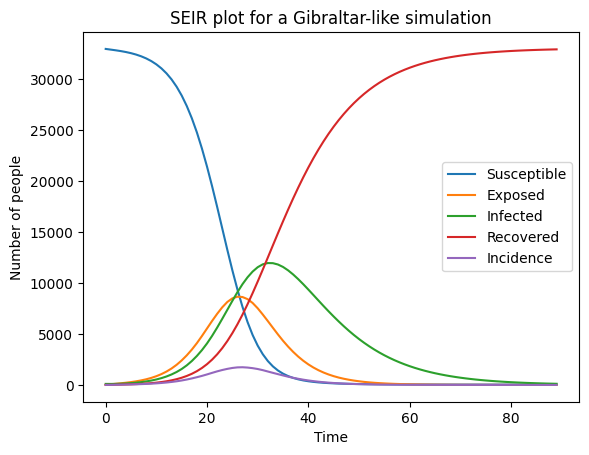

In [14]:
for column in list(compartmental_df.columns):
    plt.plot(times, compartmental_df[column], label=column)
plt.xlabel("Time")
plt.ylabel("Number of people")
plt.legend()
plt.title("SEIR plot for a Gibraltar-like simulation")

## Crude estimates for $\beta$, $\kappa$ and $\gamma$

In this section, we will use the governing ODEs:

\begin{equation}
    \frac{dS(t)}{dt} = -\beta S(t)I(t),
\end{equation}
\begin{equation}                \frac{dE(t)}{dt} =      \beta S(t)I(t) - \kappa E(t),
\end{equation}
\begin{equation}
    \frac{dI(t)}{dt} = \kappa E(t) - \gamma I(t), 
\end{equation}

\begin{equation}
    \frac{dR(t)}{dt} = \gamma I(t),
\end{equation}

to give crude estimates for what $\beta$, $\kappa$ and $\gamma$ should be as a comparison.

We will do this by estimating the gradients of the true compartmental values using `np.gradient` to retrieve an array
of estimates for $\beta$ (eq. 1) then $\gamma$ (eq. 4) and then $\kappa$ (eq. 3).

In [66]:
dS_dt = np.gradient(susceptible)
dE_dt = np.gradient(exposed)
dI_dt = np.gradient(infected)
dR_dt = np.gradient(recovered)

In [67]:
pop_size = 33078
beta_estimate = - dS_dt * pop_size / (susceptible * infected)
gamma_estimate = dR_dt / infected
kappa_estimate_eq_3 = (dI_dt + gamma_estimate * infected) / exposed
kappa_estimate_eq_2 = (beta_estimate / pop_size * susceptible * infected - dE_dt) / exposed

C:\Users\matth\AppData\Local\Temp\ipykernel_28676\3301848107.py:4: RuntimeWarning: divide by zero encountered in divide
  kappa_estimate_eq_3 = (dI_dt + gamma_estimate * infected) / exposed
C:\Users\matth\AppData\Local\Temp\ipykernel_28676\3301848107.py:5: RuntimeWarning: divide by zero encountered in divide
  kappa_estimate_eq_2 = (beta_estimate / pop_size * susceptible * infected - dE_dt) / exposed


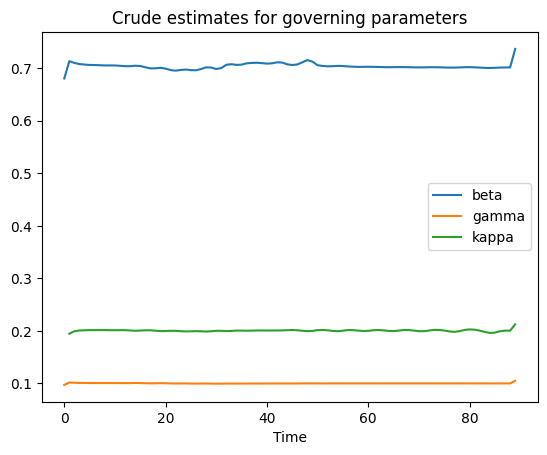

In [68]:
plt.plot(times, beta_estimate, label="beta")
plt.plot(times, gamma_estimate, label="gamma")
plt.plot(times, kappa_estimate_eq_3, label="kappa")
plt.xlabel("Time")
plt.legend()
plt.title("Crude estimates for governing parameters")
plt.savefig("seirmo_outputs/crude_estimates.png")

As expected, these are mostly flat lines around the true values we applied.

In [69]:
param_df = pd.DataFrame({"beta": beta_estimate, "gamma": gamma_estimate, "kappa_eq_3": kappa_estimate_eq_3,
                         "kappa_eq_2": kappa_estimate_eq_2})
param_df.replace(np.inf, 0, inplace=True)

# We replace any zeros with NaNs as these will not contribute to the beta, gamma and kappa values
param_df.replace(0, np.nan, inplace=True)
print(f"Mean beta: {np.mean(param_df["beta"])}, std dev beta: {np.std(param_df["beta"])}")
print(f"Mean gamma: {np.mean(param_df["gamma"])}, std dev gamma: {np.std(param_df["gamma"])}")
print(f"Mean kappa (eq 2): {np.mean(param_df["kappa_eq_2"])}, std dev kappa (eq 2): {np.std(param_df["kappa_eq_2"])}")
print(f"Mean kappa (eq 3): {np.mean(param_df["kappa_eq_3"])}, std dev kappa (eq 3): {np.std(param_df["kappa_eq_3"])}")

Mean beta: 0.7035884647894624, std dev beta: 0.0058492562266228695
Mean gamma: 0.1002589125632497, std dev gamma: 0.0007108107993307635
Mean kappa (eq 2): 0.2005470129651633, std dev kappa (eq 2): 0.0017865120775115253
Mean kappa (eq 3): 0.20054701296515595, std dev kappa (eq 3): 0.0017865120772667035


Text(0.5, 1.0, 'Crude estimates for beta, gamma and kappa at each timepoint')

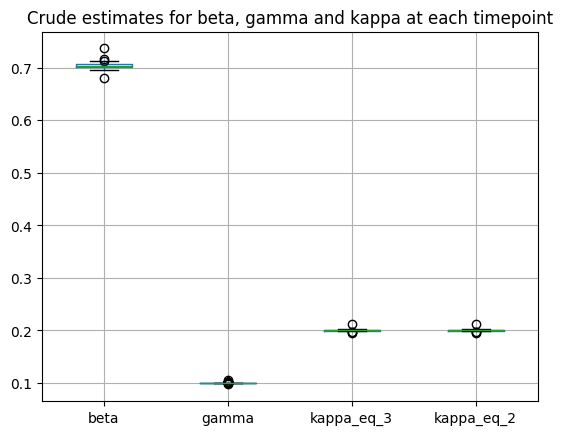

In [70]:
param_df.boxplot()
plt.title("Crude estimates for beta, gamma and kappa at each timepoint")

## Model Inference

### Set up

Here is a description of our parameters:
* $S(0)$, $E(0)$, $I(0)$, $R(0)$ - Initial $S$, $E$, $I$ and $R$ values
* $\beta$, $\kappa$, $\gamma$ - Infection Rate, Incubation Rate and Recovery Rate respectively
* $\sigma_{S}$, $\sigma_{E}$, $\sigma_{I}$, $\sigma_{R}$ - The 4 hyperparameters controlling each respective log prior

In [25]:
all_data = normalised_compartmental_values[:, :4]
initial_infected = 100

### PINTS ForwardModel

Next, we create the forward model used to perform inference. We will be using a `ReducedModel` from `seirmo` to fix/specify specific parameters
to reduce the dimensions of the parameter space to match `epiabm_rt_inference.ipynb`. These values are described in the table below.

|Parameter|Value|Reasoning|
|---|---|-------|
|$S(0)$|$1 - I(0)$|The total of all compartments must add up to $1$ for all time (after scaling out by `pop_size`).|
|$E(0)$|$0$|We can safely assume that no-one has been exposed at the start of the simulation.|
|$I(0)$|$\frac{100}{33078}$|We know that there were $100$ initial infected, and we scale out by `pop_size`.|
|$R(0)$|$0$|We also enforce that no-one has recovered at the start of the simulation.|
|$\kappa$|$0.2$|We fix $\kappa$ to see if we can recover the other values.|

In [17]:
import seirmo
import pints

class SEIRModel(pints.ForwardModel):
    def __init__(self, pop_size, initial_infected, kappa = None):
        super(SEIRModel, self).__init__()

        seir_model = seirmo.SEIRModel()
        self._model = seirmo.ReducedModel(seir_model)
        fixed_parameters = {"S0": 1 - initial_infected / pop_size, "E0": 0, "I0": initial_infected / pop_size, "R0": 0}
        if kappa:
            fixed_parameters["beta"] = kappa
        self._model.fix_parameters(fixed_parameters)
        self._kappa = kappa

    def n_outputs(self):
        # Returns number of model outputs.
        # Returns the S, E, I and R values at each timestep
        return 4

    def n_parameters(self):
        # Returns number of parameters, i.e. some of beta, kappa and gamma
        if self._kappa:
            return 2
        return 3

    def n_fixed_parameters(self):
        # Returns number of fixed parameters, i.e. 4 initial conditions (S(0), E(0), I(0) and R(0)) and potentially kappa
        if self._kappa:
            return 5
        return 4

    def simulate(self, parameters, times):
        # This ensures that we are taking the prevalence
        self._model.set_outputs(["S", "E", "I", "R"])
        compartmental_results = self._model.simulate(parameters=parameters, times=times)

        return compartmental_results

### PINTS `MultiOutputProblem` and `GaussianLogLikelihood`

We choose a Gaussian log-likelihood and an array of Gaussian log-priors for each of the different parameters of the model.

In [47]:
# Create log-likelihood
pints_model = SEIRModel(pop_size=33078, initial_infected=100, kappa=0.2)
problem = pints.MultiOutputProblem(pints_model, times, all_data)
log_likelihood = pints.GaussianLogLikelihood(problem)

C:\Users\matth\AppData\Local\Temp\ipykernel_28676\3666600987.py:13: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._model.fix_parameters(fixed_parameters)


In [48]:
# Create log-prior and log-posterior
log_prior = pints.ComposedLogPrior(
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

### Initialising multiple starting locations for the chain

In [49]:
num_chains = 4
xs = log_prior.sample(num_chains)

### Performing inference

In [50]:
n_params = log_prior.n_parameters()
transform = pints.RectangularBoundariesTransformation([0] * n_params, [4] * n_params)
mcmc = pints.MCMCController(log_posterior, num_chains, xs, method=pints.PopulationMCMC, transformation=transform)
max_iterations = 50000
mcmc.set_max_iterations(max_iterations)

chains = mcmc.run()

Using Population MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval.  i     j     Ex. i     j     Ex. i     j     Ex. i     j     Ex. Time m:s
0     4      0     1     no  0     1     no  0     1     no  0     1     no    0:00.0
1     8      6     5     yes 3     6     yes 7     3     yes 0     8     no    0:00.1
2     12     4     9     yes 8     4     yes 9     5     yes 1     9     yes   0:00.1
3     16     2     7     yes 7     5     yes 0     8     no  2     8     yes   0:00.1
20    84     3     9     no  4     9     no  2     1     yes 3     8     no    0:00.7
40    164    8     7     yes 2     5     yes 7     6     no  5     6     no    0:01.2
60    244    2     9     no  1     2     yes 2     5     no  0     9     no    0:01.8
80    324    8     0     no  9     0     no  6     5     yes 8     5     yes   0:02.4
100   404    3     5     yes 4     7     yes 1     5     no  4     1     no    0:03.0
120   484    0     2     no  5     8     no  6     0     no  2     6 

### Saving chains

In [51]:
param_names = ['Infection Rate (beta)', 'Recovery Rate (gamma)',
               'sigma_S', 'sigma_E', 'sigma_I', 'sigma_R']

In [52]:
for i, chain in enumerate(chains):
    df = pd.DataFrame(chain, columns=param_names)
    df.to_csv(f"seirmo_outputs/chain_data/chain_{i}.csv")

## Plots

### Recovering chains from .csv files

In [53]:
list_of_chains = []
for i in range(4):
    df = pd.read_csv(f"seirmo_outputs/chain_data/chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

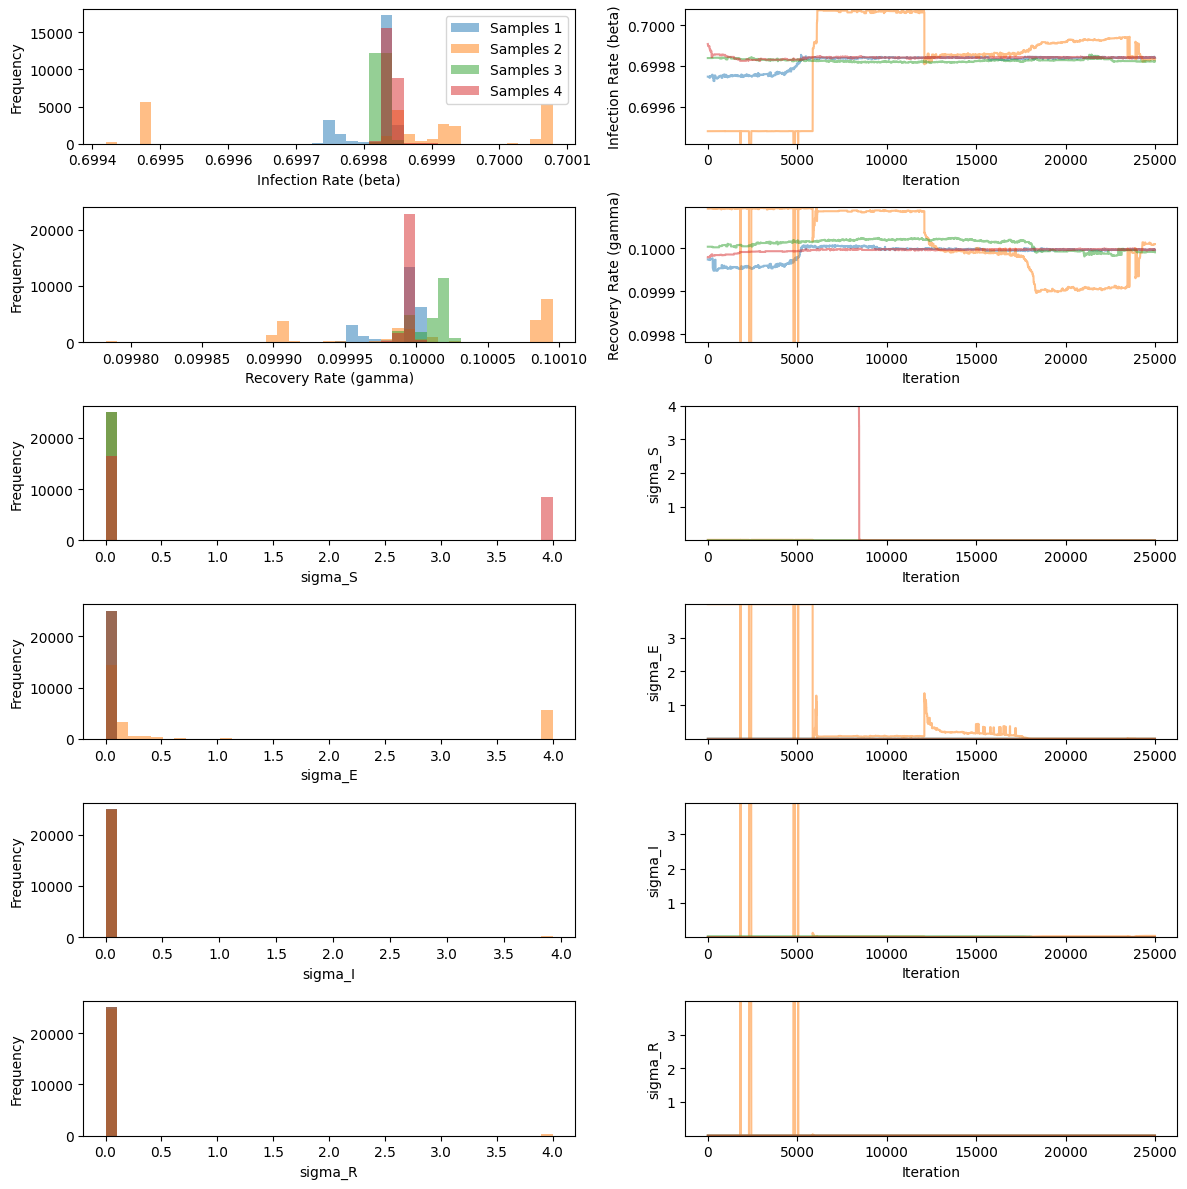

In [71]:
import pints.plot
pints.plot.trace(chains, parameter_names=param_names)
plt.show()

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [55]:
r_hat_values = pints.rhat(chains, warm_up=0.5)
for i in range(len(param_names)):
    print(f"R_hat value for {param_names[i]}: {r_hat_values[i]}")

R_hat value for Infection Rate (beta): 1.0406264608093025
R_hat value for Recovery Rate (gamma): 1.830158939241063
R_hat value for sigma_S: 1.7582768369854809
R_hat value for sigma_E: 1.3838966772878483
R_hat value for sigma_I: 1.01167102707215
R_hat value for sigma_R: 1.009632277944793


We will now discount the first half of the iterations.

In [56]:
max_iterations = 50000
chains = chains[:, int(max_iterations / 2):]

### Predicted time series plots

#### Chain 1

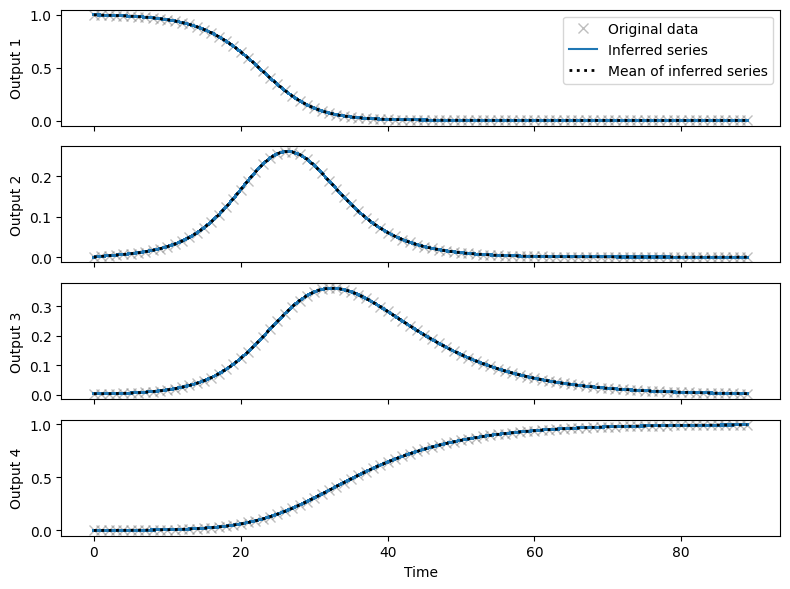

In [57]:
pints.plot.series(chains[0, :], problem)
plt.show()

#### Chain 2

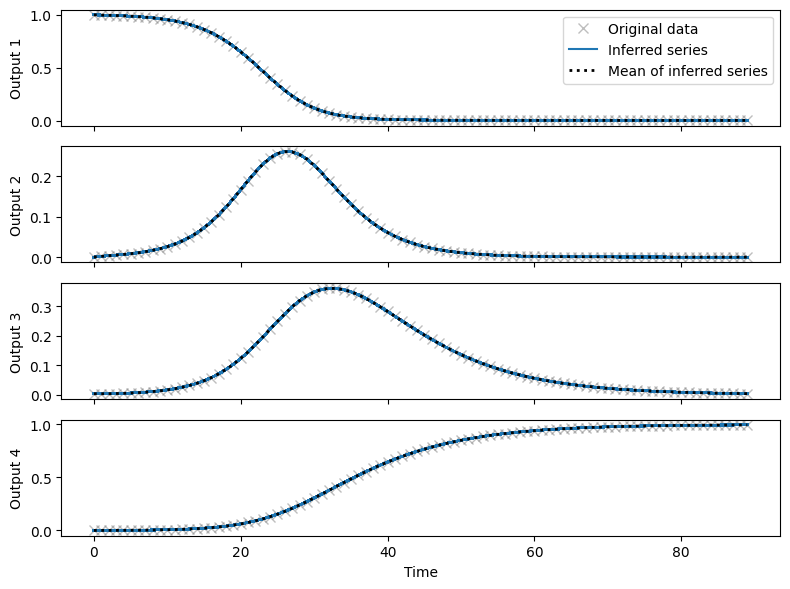

In [58]:
pints.plot.series(chains[1, :], problem)
plt.show()

#### Chain 3

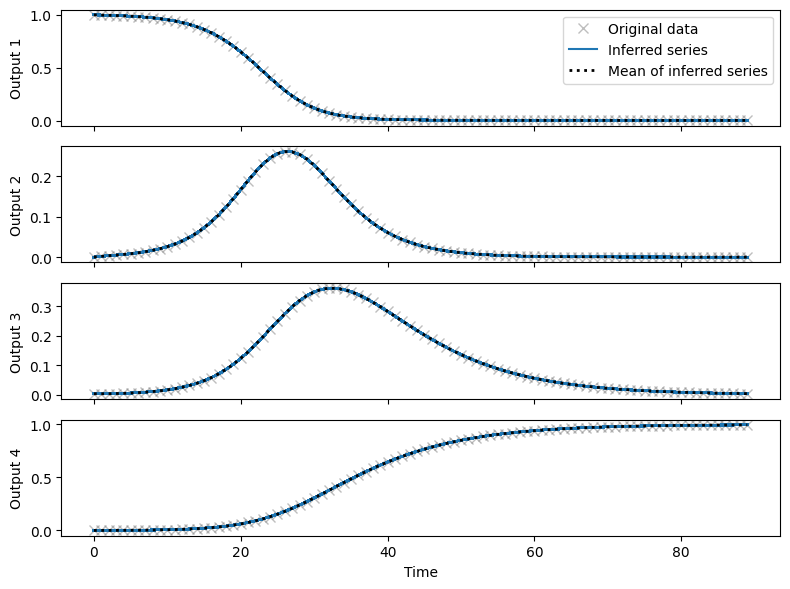

In [59]:
pints.plot.series(chains[2, :], problem)

#### Chain 4

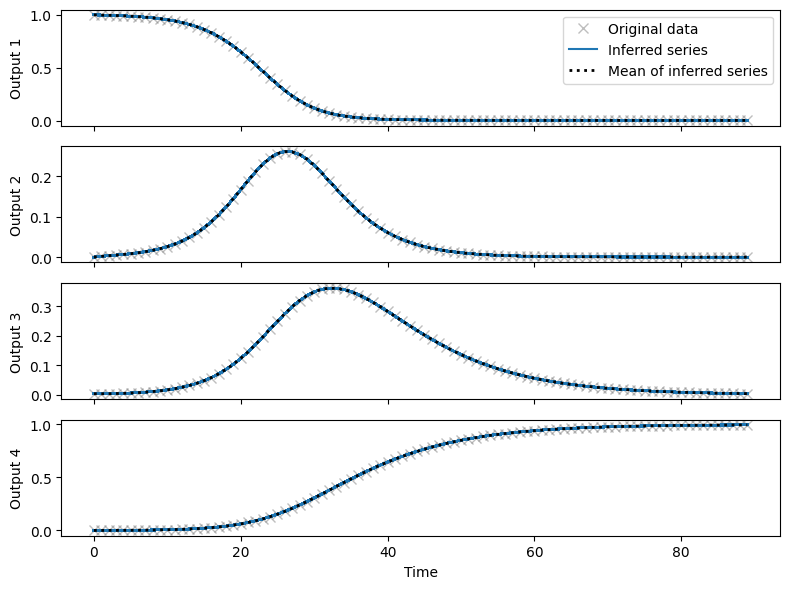

In [60]:
pints.plot.series(chains[3, :], problem)
plt.show()

This is to see whether there are any correlations between parameters.

### Plotting histograms of $\beta$ and $\gamma$

In [62]:
chains_df = pd.DataFrame(columns=param_names + ['chain'])
for i in range(4):
    chain_i_df = pd.DataFrame(chains[i], columns=param_names)
    for population_parameter in ["sigma_S", "sigma_E", "sigma_I", "sigma_R"]:
        chain_i_df[population_parameter] = pop_size * chain_i_df[population_parameter]
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_28676\3266292034.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


array([[<Axes: title={'center': 'Infection Rate (beta)'}>,
        <Axes: title={'center': 'Recovery Rate (gamma)'}>]], dtype=object)

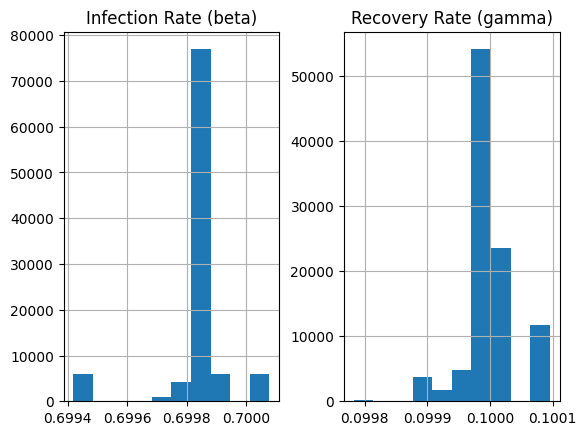

In [63]:
chains_df.hist(column=["Infection Rate (beta)", "Recovery Rate (gamma)"])

In [65]:
print(f"Mean beta: {np.mean(chains_df["Infection Rate (beta)"])}," 
      f" std dev beta: {np.std(chains_df["Infection Rate (beta)"])}, actual beta: 0.7")
print(f"Mean gamma: {np.mean(chains_df["Recovery Rate (gamma)"])}," 
      f" std dev gamma: {np.std(chains_df["Recovery Rate (gamma)"])}, actual gamma: 0.1")

Mean beta: 0.6998301252562236, std dev beta: 0.00010738021612503914, actual beta: 0.7
Mean gamma: 0.10000356206048526, std dev gamma: 4.12519463228676e-05, actual gamma: 0.1


### Conclusion

The above shows that we can successfully estimate $\beta$ and $\gamma$ with this problem, given values from the 
$S$, $E$, $I$ and $R$ compartments.